In [62]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [63]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [64]:
sql = """
     select * from population
     where fips = '23'
     """

In [65]:
import pandas as pd

me_df = pd.read_sql(sql, con=conn)
me_df.head() #show the top 5 rows

/tmp/ipykernel_6948/1655376101.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  me_df = pd.read_sql(sql, con=conn)


,fips,pop,year
0,23,1283673,2005
1,23,1321574,2006
2,23,1317207,2007
3,23,1316456,2008
4,23,1318301,2009


In [66]:
q1_sql = """
SELECT
  year,
  pop,
  ROUND(
    100.0 * (pop - LAG(pop) OVER (ORDER BY year))
    / NULLIF(LAG(pop) OVER (ORDER BY year), 0),
    2
  ) AS growth_rate_pct
FROM population
WHERE fips = '23'
ORDER BY year;
"""
q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head()

/tmp/ipykernel_6948/784310196.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,year,pop,growth_rate_pct
0,2005,1283673,NaN
1,2006,1321574,2.95
2,2007,1317207,-0.33
3,2008,1316456,-0.06
4,2009,1318301,0.14


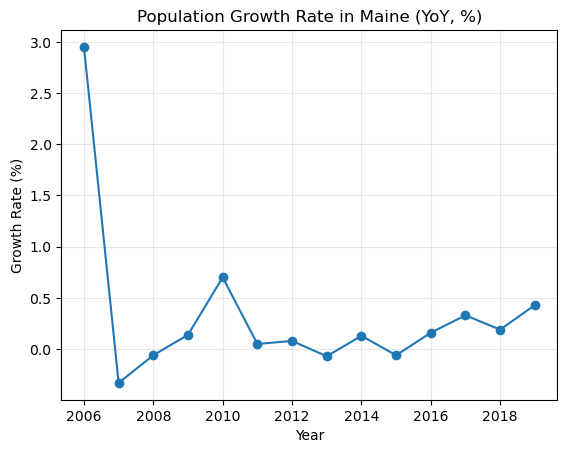

In [67]:
import matplotlib.pyplot as plt

plt.plot(q1_df["year"], q1_df["growth_rate_pct"], marker="o")
plt.title("Population Growth Rate in Maine (YoY, %)")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()


# **Q1 Explanation (Maine):**  
The chart shows Maine’s year-over-year population growth from 2005 to 2019.  
Growth peaked in 2006 at about 2.95%.  
Several years show slight negative growth (2007, 2008, 2013, 2015), indicating small population declines.  
Overall, Maine’s population has been relatively stable with only modest increases each year.

In [68]:
q2_sql = """
SELECT
  p.year,
  p.pop AS population,
  i.income AS median_income
FROM population p
JOIN income i
  ON p.fips = i.fips
 AND p.year = i.year
WHERE p.fips = '23'
ORDER BY p.year;
"""
q2_df = pd.read_sql(q2_sql, con=conn)   # <— use conn here
q2_df.head()

/tmp/ipykernel_6948/2920375363.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(q2_sql, con=conn)   # <— use conn here


,year,population,median_income
0,2005,1283673,42801
1,2006,1321574,43439
2,2007,1317207,45888
3,2008,1316456,46581
4,2009,1318301,45734


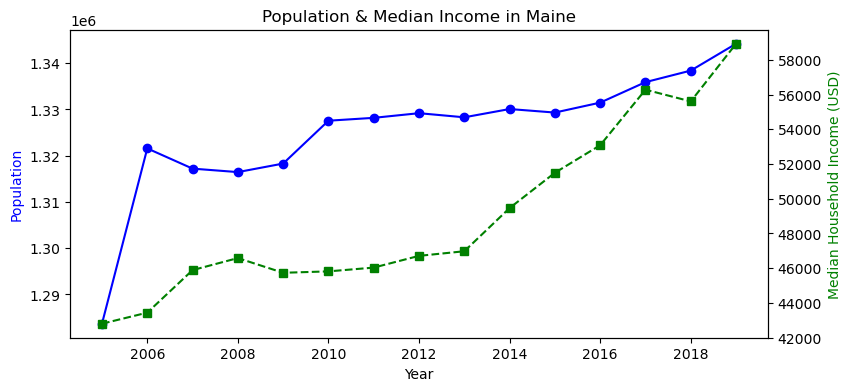

In [69]:
fig, ax1 = plt.subplots(figsize=(9,4))

# Left axis: Population
ax1.plot(q2_df["year"], q2_df["population"], marker="o", color="blue")
ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="blue")

# Right axis: Income
ax2 = ax1.twinx()
ax2.plot(q2_df["year"], q2_df["median_income"], marker="s", linestyle="--", color="green")
ax2.set_ylabel("Median Household Income (USD)", color="green")

plt.title("Population & Median Income in Maine")
plt.show()

# Q2 Explanation (Maine):  
The dual-axis chart shows population (blue) and median household income (green) in Maine.  
Population growth is very modest, showing only small fluctuations each year.  
In contrast, income trends steadily upward across the period shown.  
This indicates that while Maine’s population is relatively flat, household incomes have been increasing consistently.

In [70]:
q3_sql = """
WITH pop_series AS (
  SELECT
    year,
    pop,
    LAG(pop) OVER (ORDER BY year) AS prev_pop
  FROM population
  WHERE fips = '23'
)
SELECT
  year,
  pop,
  (pop - prev_pop) AS yoy_change
FROM pop_series
WHERE prev_pop IS NOT NULL
ORDER BY yoy_change DESC
LIMIT 5;
"""
q3_df = pd.read_sql(q3_sql, con=conn)
q3_df

/tmp/ipykernel_6948/902824565.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q3_df = pd.read_sql(q3_sql, con=conn)


,year,pop,yoy_change
0,2006,1321574,37901
1,2010,1327567,9266
2,2019,1344212,5808
3,2017,1335907,4428
4,2018,1338404,2497


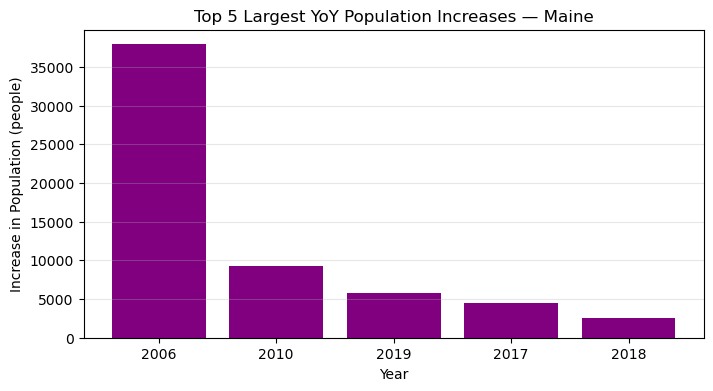

In [71]:
plt.figure(figsize=(8,4))
plt.bar(q3_df["year"].astype(str), q3_df["yoy_change"], color="purple")
plt.title("Top 5 Largest YoY Population Increases — Maine")
plt.xlabel("Year")
plt.ylabel("Increase in Population (people)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Q3 Explanation (Maine):
The chart shows the top five years with the largest year-over-year population increases in Maine.  
These years represent short-term spikes compared to the generally modest population growth trend.  
They may reflect economic conditions, migration flows, or other demographic changes.  
Overall, Maine’s population growth remains limited, but these years stand out relative to surrounding years.

# Lab 6 Finished — What I Learned

In this lab I learned how to pull data from a database and look at it in Jupyter with the state Maine.

- Q1: I found how Maine’s population changes each year. Most years it stayed about the same, with a few small drops.  
- Q2: I compared population with income. Population didn’t change much, but income kept going up over time.  
- Q3: I asked my own question about which years had the biggest population jumps. A few years stood out, but overall Maine’s growth is pretty small.  
